In [1]:
# imports
import json
import gmaps
import numpy as np
import pandas as pd
import datetime as dtt
import ipywidgets as widgets

from leuvenair.myutils.utility import readJson, getSensorData, interpolate1D, getSensorInterpolatedData 
from leuvenair.myutils.gmap_utils import get_gmap_figure, get_closest_idx

%matplotlib inline
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# read all the leuvenair sensor latitudes and longitudes
# Note: fields which are not available are specified -9999
sensor_la = readJson('./leuvenair/LEUVENAIRmeta_final.json')
LAT_la = sensor_la['LAT']
LON_la = sensor_la['LON']
print('All keys in the leuvenair json file are: ',sensor_la.keys())

Note: sensors 8799 and 8827 are repeated in the json file!
All keys in the leuvenair json file are:  dict_keys(['SDS011ID', 'DHTID', 'EXPORT', 'LAT', 'LON', 'STREET', 'POSTALCODE', 'CITY', 'HEIGHT', 'SENSOR_POSITION', 'INDUSTRY', 'WOODSTOVES', 'TRAFFIC', 'SVL', 'NO2_CN'])


In [3]:
# Get all the field names in the leuvenair datadump
varname = list(pd.read_csv('./leuvenair/LEUVENAIRfulldump2019.csv', skiprows=0, nrows = 0, usecols = None).columns)
print('All variable names in the leuvenair datadump are :', varname)

All variable names in the leuvenair datadump are : ['DATEUTC', 'LAT', 'LON', 'SDS011ID', 'PM2.5', 'PM10', 'DHTID', 'TEMPERATURE', 'HUMIDITY', 'OBSID']


In [4]:
# This is going to take some time ~1-5 min
# read leuvenair sensor datadump
fields_la = getSensorData('./leuvenair/LEUVENAIRmeta_final.json','./leuvenair/LEUVENAIRfulldump2019.csv')

Note: sensors 8799 and 8827 are repeated in the json file!
The complete pandas frame has shape  (13984608, 10)
sensor: 6561  1st obs: 2019-01-01 00:01:07  last: 2019-12-31 23:59:37 median dt:  2  min, total obs: 236287
sensor: 8745  1st obs: 2019-01-01 00:01:06  last: 2019-12-31 23:59:47 median dt:  2  min, total obs: 188253
sensor: 8765  1st obs: 2019-01-01 00:01:30  last: 2019-12-31 23:59:52 median dt:  2  min, total obs: 192953
sensor: 8769  1st obs: 2019-01-01 00:00:52  last: 2019-12-31 23:58:53 median dt:  2  min, total obs: 184062
sensor: 8773  1st obs: 2019-01-20 02:37:25  last: 2019-12-31 23:59:00 median dt:  2  min, total obs: 139201
sensor: 8775 did not record any observation.
sensor: 8777  1st obs: 2019-01-01 00:00:46  last: 2019-12-31 23:58:07 median dt:  2  min, total obs: 189325
sensor: 8779 did not record any observation.
sensor: 8781  1st obs: 2019-01-01 00:00:43  last: 2019-10-13 12:10:43 median dt:  2  min, total obs: 137546
sensor: 8783  1st obs: 2019-01-03 06:35:16 

sensor: 9825  1st obs: 2019-01-01 00:01:51  last: 2019-12-31 23:58:31 median dt:  2  min, total obs: 145450
sensor: 10045  1st obs: 2019-01-01 00:00:11  last: 2019-12-31 23:59:55 median dt:  2  min, total obs: 204151
sensor: 10739 did not record any observation.
sensor: 10741  1st obs: 2019-01-05 09:48:27  last: 2019-12-03 09:33:40 median dt:  2  min, total obs: 178224
sensor: 11201 did not record any observation.
sensor: 11529  1st obs: 2019-01-01 00:01:54  last: 2019-12-31 23:57:37 median dt:  2  min, total obs: 202105
sensor: 12030  1st obs: 2019-01-01 00:00:34  last: 2019-12-31 23:58:29 median dt:  2  min, total obs: 203502
sensor: 12183  1st obs: 2019-01-01 00:01:18  last: 2019-12-02 23:59:31 median dt:  2  min, total obs: 186477
sensor: 12505  1st obs: 2019-01-01 00:00:06  last: 2019-12-31 23:58:23 median dt:  2  min, total obs: 184795
sensor: 12554  1st obs: 2019-01-01 00:02:14  last: 2019-12-31 23:57:46 median dt:  2  min, total obs: 206207
sensor: 12609 did not record any obse

In [5]:
print('All sensors are: ',fields_la.keys())

All sensors are:  dict_keys(['6561', '8745', '8765', '8769', '8773', '8775', '8777', '8779', '8781', '8783', '8785', '8787', '8789', '8791', '8793', '8795', '8797', '8799', '8801', '8803', '8805', '8807', '8809', '8811', '8813', '8815', '8817', '8819', '8821', '8823', '8825', '8827', '8829', '8831', '8833', '8835', '8837', '8839', '8841', '8843', '8845', '8849', '8853', '8855', '8857', '8859', '8950', '8993', '9555', '9559', '9561', '9563', '9565', '9567', '9569', '9571', '9577', '9579', '9583', '9585', '9587', '9589', '9591', '9593', '9595', '9597', '9599', '9601', '9603', '9605', '9609', '9611', '9613', '9619', '9621', '9623', '9625', '9629', '9631', '9633', '9635', '9637', '9639', '9643', '9753', '9801', '9812', '9825', '10045', '10739', '10741', '11201', '11529', '12030', '12183', '12505', '12554', '12609', '12855', '13526', '13528', '13649', '15986', '16358', '16551', '16809', '19832', '19850', '21569', '22953', '24241', '24719', '26686', '30627'])


In [8]:
# extract time series data (1 minute resolution) for each sensor
# X is of shape 1 X #times
# Y is of shape #sensors X #times
X1, Y1, xaxis = getSensorInterpolatedData(fields_la,tstart='2019-08-04 00:00:00',tstop='2019-08-05 00:00:00',fid=4)
weights1=np.nanmean(Y1,axis=1)

Extracting data over duration  1 days 00:00:00  starting at  2019-08-04 00:00:00
Sampling resolution =  1  minute


In [9]:
# add layer on top of the base map
fobj1 = get_gmap_figure(LAT_la,LON_la,'./leuvenair/apikey.txt')
locations = list(zip(LAT_la,LON_la)) # provide the latitudes and longitudes
heatmap_layer = gmaps.heatmap_layer(locations, weights=weights1)
heatmap_layer.point_radius = 0.005
heatmap_layer.dissipating = False
fobj1.add_layer(heatmap_layer)
fobj1

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

In [11]:
idx = get_closest_idx(LAT_la, LON_la, LAT_star=50.8798, LON_star=4.7005)
sensor_la['STREET'][idx[0]]

'Amerikalaan'

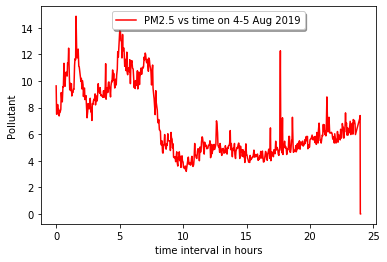

In [17]:
plt.plot(np.squeeze(X1/(60)),np.squeeze(Y1[idx[0],:]), 'r', label = 'PM2.5 vs time on 4-5 Aug 2019')
left, right = plt.xlim()
plt.xlim(left,right)
plt.xlabel('time interval in hours')
plt.ylabel('Pollutant')
legend = plt.legend(loc='upper center', shadow=True)